In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor

sam = sam_model_registry["vit_b"](checkpoint="./sam_vit_b_01ec64.pth")
# sam.to(device='cuda')

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [2]:
mask_generator = SamAutomaticMaskGenerator(sam)

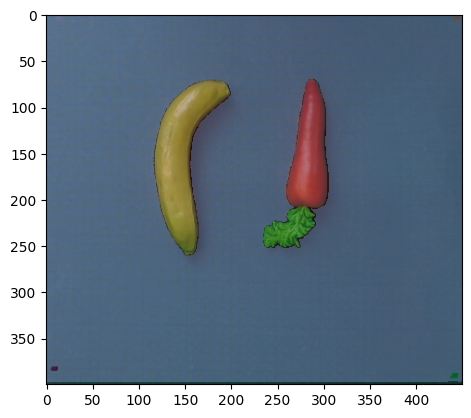

In [3]:
image = cv2.imread("./samples/rgb.png")[80:, 160:610] 
# So, this means that src.at(i,j) is using (i,j) as (row,column) but Point(x,y) is using (x,y) as (column,row)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image)
plt.imshow(image)
show_anns(masks)

In [5]:
np.savez("masks.npz", masks=masks)

In [4]:
print(len(masks))
masks[0].keys()

37


dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

In [22]:
sizes = [m['segmentation'].sum() for m in masks]
sorted(sizes)

[38,
 122,
 126,
 256,
 371,
 424,
 527,
 535,
 643,
 782,
 854,
 1341,
 1506,
 2404,
 2679,
 2721,
 2791,
 2942,
 3365,
 3871,
 4051,
 4480,
 4650,
 4695,
 5222,
 6424,
 6984,
 7086,
 8315,
 11706,
 12825,
 12849,
 17636,
 28759,
 51480,
 63805,
 473226]

In [23]:
masks[0]['bbox']

[0, 0, 890, 716]

In [2]:
image = cv2.imread("./easy.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor = SamPredictor(sam)
predictor.set_image(image)

In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

sam = sam_model_registry["vit_h"](checkpoint="./sam_vit_h_4b8939.pth")

In [2]:
import warnings

onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [9]:
image = cv2.imread("./samples/3.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ort_session = onnxruntime.InferenceSession(onnx_model_path)
sam.to(device='cuda')
predictor = SamPredictor(sam)
predictor.set_image(image)

In [10]:
image_embedding = predictor.get_image_embedding().cpu().numpy()
image_embedding.shape

(1, 256, 64, 64)

(400, 450, 3)


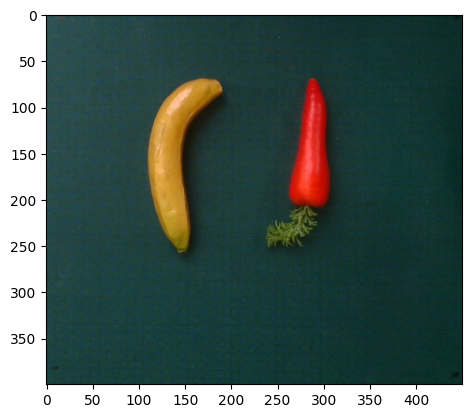

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("./samples/rgb.png")
img = img[80:, 160:610]
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [29]:
masks = np.load("./samples/masks.npz", allow_pickle=True)
masks = list(masks.values())[0]

[0, 1, 449, 397] 224 199
[110, 69, 80, 187] 150 162
[264, 69, 42, 138] 285 138
[238, 207, 54, 44] 265 229
[238, 69, 68, 182] 272 160
[110, 69, 196, 187] 208 162
[6, 380, 7, 5] 9 382
[438, 387, 8, 5] 442 389


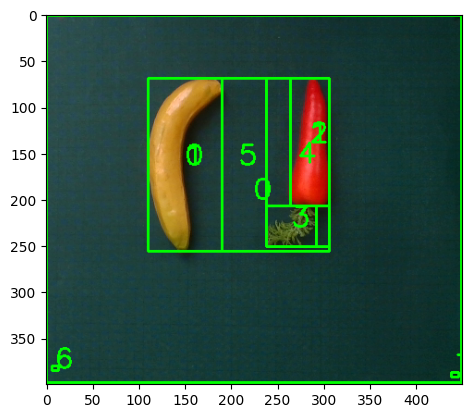

In [40]:
for idx, mask in enumerate(masks):
    # print x, y, w, h and center point
    center_x, center_y = mask['bbox'][0] + mask['bbox'][2]//2, mask['bbox'][1] + mask['bbox'][3]//2
    print(mask['bbox'], center_x, center_y)
    # draw rectangle
    # XYWH to X1Y1X2Y2
    cv2.rectangle(img, 
                  (mask['bbox'][0], mask['bbox'][1]), 
                  (mask['bbox'][0] + mask['bbox'][2], 
                   mask['bbox'][1] + mask['bbox'][3]), 
                   (0, 255, 0), 2)
    # draw a number label on the center of the rectangle
    cv2.putText(img, str(idx), (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

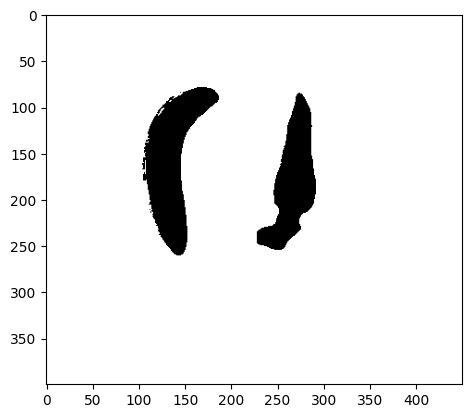

In [11]:
import numpy as np
import matplotlib.pyplot as plt

depth = np.load("./samples/depth_data.npy")[80:, 160:610]
depth = np.where(depth < 0.63, 0, 255)
plt.imshow(depth, cmap='gray')